# Titanic

In [519]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import math 

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, skew, mode
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier,Pool
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split

This is an edit of an already existing notebook:
https://www.kaggle.com/startupsci/titanic-data-science-solutions

I used some of his data cleaning solutions for personal practice.

## Reading data and info

In [3]:
traindf = pd.read_csv('train.csv')
traindf.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
testdf = pd.read_csv('test.csv')
testdf.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
combine = [traindf,testdf]

In [6]:
traindf.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

Categorical: Survived, pclass, sibSp, parch, embarked, sex

Numerical: Age, fare

### info

In [7]:
testdf.info()
print('_'*50)
print('')
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
__________________________________________________

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1 

### describe

In [8]:
#numerical
traindf.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Total samples are 891 or 40% of the actual number of passengers on board the Titanic (2,224).

Survived is a categorical feature with 0 or 1 values.

Around 38% samples survived representative of the actual survival rate at 32%.

Most passengers (> 75%) did not travel with parents or children.

Nearly 30% of the passengers had siblings and/or spouse aboard.

Fares varied significantly with few passengers (<1%) paying as high as $512.

Few elderly passengers (<1%) within age range 65-80

In [9]:
#categorical
traindf.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Gale, Mr. Shadrach",male,1601,C23 C25 C27,S
freq,1,577,7,4,644


# Find corelation to survival

In [10]:
traindf.head()
#our assumptions state: females, young people and upper class citizens have survival priority.

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Sex

In [11]:
traindf[['Sex','Survived']].groupby(['Sex'], as_index = False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


Pclass

In [12]:
traindf[['Pclass','Survived']].groupby(['Pclass'], as_index = False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


SibSp

In [13]:
traindf[['SibSp','Survived']].groupby(['SibSp'], as_index = False).mean()

,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


ParCH

In [14]:
traindf[['Parch','Survived']].groupby(['Parch'], as_index = False).mean()

,Parch,Survived
0,0,0.343658
1,1,0.550847
2,2,0.500000
3,3,0.600000
4,4,0.000000
5,5,0.200000
6,6,0.000000


# visualize corelation data

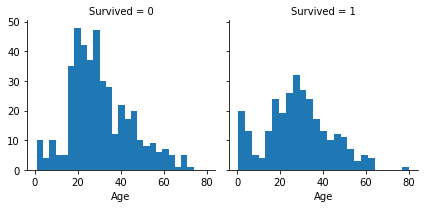

In [15]:
g = sns.FacetGrid(traindf, col='Survived')
g.map(plt.hist, 'Age', bins=25)
plt.show()

Age and class:

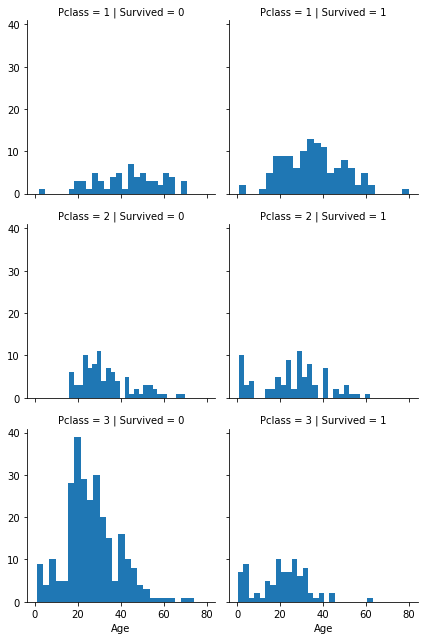

In [16]:
g = sns.FacetGrid(traindf, col='Survived', row = 'Pclass')
g.map(plt.hist, 'Age', bins=25)
plt.show()

Embarked

C:\Users\Hmund\Documents\Anaconda\envs\R Jup\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\Hmund\Documents\Anaconda\envs\R Jup\lib\site-packages\seaborn\axisgrid.py:648: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


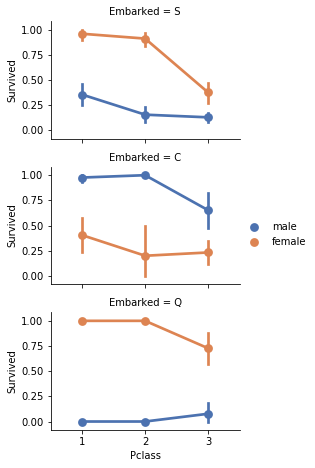

In [17]:
grid = sns.FacetGrid(traindf, row='Embarked', height=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()
plt.show()

C:\Users\Hmund\Documents\Anaconda\envs\R Jup\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


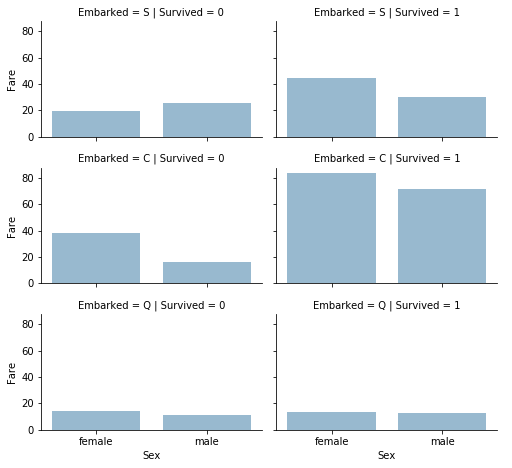

In [18]:
grid = sns.FacetGrid(traindf, row='Embarked', col='Survived', height=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()
plt.show()

# Wrangle data

### Drop ticket and cabin columns

In [19]:
traindf = traindf.drop(['Cabin', 'Ticket'], axis = 1)
testdf = testdf.drop(['Cabin', 'Ticket'], axis = 1)
combine = [traindf, testdf]

In [20]:
traindf.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [21]:
traindf.shape

(891, 10)

## Create a title column based on names

In [22]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(traindf['Title'], traindf['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [23]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'],'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle','Miss')
    dataset['Title'] = dataset['Title'].replace('Ms','Miss')
    dataset['Title'] = dataset['Title'].replace('Mme','Mrs')

In [24]:
traindf[['Title','Survived']].groupby('Title', as_index = False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


### convert the title column to categorical

In [25]:
titlemap = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(titlemap)
    dataset['Title'] = dataset['Title'].fillna(0)

In [26]:
traindf.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,8.4583,Q,1
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,51.8625,S,1
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,21.0750,S,4
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,11.1333,S,3
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,30.0708,C,3


### Drop passenger and name columns

In [27]:
traindf = traindf.drop(['Name', 'PassengerId'], axis = 1)
testdf = testdf.drop(['Name'], axis = 1)
combine = [traindf,testdf]

In [28]:
traindf.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,S,1
1,1,1,female,38.0,1,0,71.2833,C,3
2,1,3,female,26.0,0,0,7.9250,S,2
3,1,1,female,35.0,1,0,53.1000,S,3
4,0,3,male,35.0,0,0,8.0500,S,1


### Categorize sex column

In [29]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map({'female':1, 'male':0}).astype(int)

In [30]:
traindf.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


# Completing a numerical continuous feature

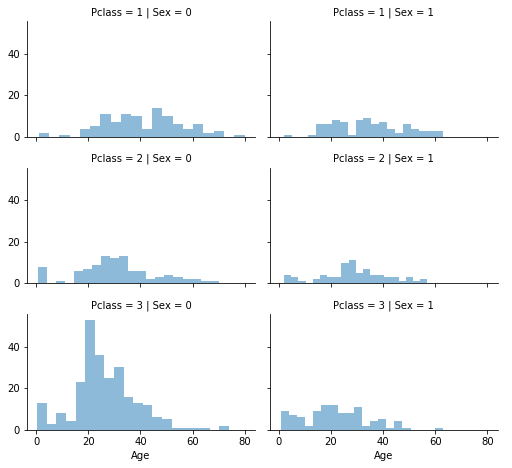

In [31]:
grid = sns.FacetGrid(traindf, row='Pclass', col='Sex', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()
plt.show()

### Guess ages

In [32]:
guess_ages = np.zeros((2,3))
guess_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

In [33]:
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

traindf.head()        

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1


In [34]:
traindf['AgeBand']= pd.cut(traindf['Age'],5)
traindf[['AgeBand', 'Survived']].groupby(traindf['AgeBand'], as_index = True).mean()

,Survived
AgeBand,
"(-0.08, 16.0]",0.550000
"(16.0, 32.0]",0.337374
"(32.0, 48.0]",0.412037
"(48.0, 64.0]",0.434783
"(64.0, 80.0]",0.090909


In [35]:
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
traindf.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,0,1,1,0,7.2500,S,1,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,C,3,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,S,2,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,S,3,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,S,1,"(32.0, 48.0]"


In [36]:
traindf = traindf.drop(['AgeBand'], axis=1)
combine = [traindf, testdf]
traindf.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1
1,1,1,1,2,1,0,71.2833,C,3
2,1,3,1,1,0,0,7.9250,S,2
3,1,1,1,2,1,0,53.1000,S,3
4,0,3,0,2,0,0,8.0500,S,1


### Create an 'isAlone' column

In [37]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

traindf[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [38]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

traindf[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [39]:
traindf = traindf.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
testdf = testdf.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [traindf, testdf]

traindf.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,S,1,0
1,1,1,1,2,71.2833,C,3,0
2,1,3,1,1,7.9250,S,2,1
3,1,1,1,2,53.1000,S,3,0
4,0,3,0,2,8.0500,S,1,1


### Create a Pclass*sex column

In [40]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

traindf.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


In [41]:
freq_port = traindf.Embarked.dropna().mode()[0]
freq_port

'S'

In [42]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
traindf[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [43]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

traindf.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,7.2500,0,1,0,3
1,1,1,1,2,71.2833,1,3,0,2
2,1,3,1,1,7.9250,0,2,1,3
3,1,1,1,2,53.1000,0,3,0,2
4,0,3,0,2,8.0500,0,1,1,6


In [44]:
testdf['Fare'].fillna(testdf['Fare'].dropna().median(), inplace=True)
testdf.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,7.8292,2,1,1,6
1,893,3,1,2,7.0000,0,3,0,6
2,894,2,0,3,9.6875,2,1,1,6
3,895,3,0,1,8.6625,0,1,1,3
4,896,3,1,1,12.2875,0,3,0,3


In [45]:
traindf['FareBand'] = pd.qcut(traindf['Fare'], 4)
traindf[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [46]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

traindf = traindf.drop(['FareBand'], axis=1)
combine = [traindf, testdf]
    
traindf.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,0,0,1,0,3
1,1,1,1,2,3,1,3,0,2
2,1,3,1,1,1,0,2,1,3
3,1,1,1,2,3,0,3,0,2
4,0,3,0,2,1,0,1,1,6
5,0,3,0,1,1,2,1,1,3
6,0,1,0,3,3,0,1,1,3
7,0,3,0,0,2,0,4,0,0
8,1,3,1,1,1,0,3,0,3
9,1,2,1,0,2,1,3,0,0


# Create our ML model

In [47]:
traindf.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,0,0,1,0,3
1,1,1,1,2,3,1,3,0,2
2,1,3,1,1,1,0,2,1,3
3,1,1,1,2,3,0,3,0,2
4,0,3,0,2,1,0,1,1,6


In [48]:
testdf.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,0,2,1,1,6
1,893,3,1,2,0,0,3,0,6
2,894,2,0,3,1,2,1,1,6
3,895,3,0,1,1,0,1,1,3
4,896,3,1,1,1,0,3,0,3


# Statsmodels - Linear regression

In [60]:
import statsmodels.api as sm

In [50]:
X = traindf.iloc[:,1:10].values
y = traindf.iloc[:,0:1].values

In [51]:
x1 = sm.add_constant(X)
results = sm.OLS(y,x1).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     70.66
Date:                Wed, 18 Aug 2021   Prob (F-statistic):           1.24e-89
Time:                        15:37:49   Log-Likelihood:                -401.34
No. Observations:                 891   AIC:                             820.7
Df Residuals:                     882   BIC:                             863.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4845      0.090      5.388      0.000       0.308       0.661
x1            -0.1656      0.021     -7.744      0.000      -0.208      -0.124
x2             0.4350      0.032     13.776      0.000       0.373       0.497
x3            -0.0048      0.004     -1.260      0.208      -0.012       0.003
x4            -0.0103      0.019     -0.540      0.589      -0.048       0.027
x5             0.0478      0.020      2.336      0.020       0.008       0.088
x6             0.0723      0.015      4.755      0.000       0.042       0.102
x7             0.0154      0.035      0.435      0.664      -0.054       0.085
x8             0.0006      0.002      0.313      0.754      -0.003       0.004
==============================================================================
Omnibus:                       34.279   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.284
Skew:                           0.495   Prob(JB):                     8.02e-09
Kurtosis:                       3.152   Cond. No.                         127.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# SKlearn 

Use this:

In [507]:
Train = traindf.copy()
Test = testdf.copy()

In [508]:
X_train = Train.drop("Survived", axis=1)
y_train = Train["Survived"]
X_test  = Test.drop(["PassengerId"], axis=1).copy()

In [509]:
train_x, val_x, train_y, val_y = train_test_split(X_train, y_train, random_state=1, test_size=0.25)

rfc_model = RandomForestClassifier(random_state=0).fit(train_x, train_y)
perm = PermutationImportance(rfc_model, random_state=1).fit(val_x, val_y)
eli5.show_weights(perm, feature_names = val_x.columns.tolist(), top=20)

Weight,Feature
0.0879 ± 0.0146,Title
0.0798 ± 0.0560,Sex
0.0709 ± 0.0174,Pclass
0.0368 ± 0.0223,Fare
0.0323 ± 0.0313,Embarked
0.0126 ± 0.0119,Age
0.0090 ± 0.0160,Age*Class
-0.0054 ± 0.0208,IsAlone


In [510]:
def predictor(ml):          
    model = ml.fit(X_train,y_train)
    print('Score : {}'.format(model.score(X_train,y_train)))
    global y_pred
    y_pred = model.predict(X_test)

### Try to keep scores lower, but as close to 0.867564534231201 as possible 

In [526]:
predictor(KNeighborsClassifier(algorithm = 'brute', n_neighbors = 5, n_jobs=-1,  
                               metric = 'minkowski', p = 2, weights='uniform', leaf_size=60))
KNC = y_pred

Score : 0.8507295173961841


In [512]:
predictor(DecisionTreeClassifier(criterion = 'entropy',max_depth=10, random_state = 10))
DTC = y_pred

Score : 0.8653198653198653


In [513]:
predictor(CatBoostClassifier(iterations=2800, learning_rate= .005, eval_metric='AUC'))
CBC = y_pred

0:	total: 1.13ms	remaining: 3.16s
1:	total: 2.49ms	remaining: 3.48s
2:	total: 3.81ms	remaining: 3.55s
3:	total: 5.13ms	remaining: 3.59s
4:	total: 6.44ms	remaining: 3.6s
5:	total: 7.64ms	remaining: 3.56s
6:	total: 8.96ms	remaining: 3.57s
7:	total: 10.2ms	remaining: 3.56s
8:	total: 11.5ms	remaining: 3.56s
9:	total: 12.8ms	remaining: 3.57s
10:	total: 14.2ms	remaining: 3.6s
11:	total: 15.5ms	remaining: 3.6s
12:	total: 16.7ms	remaining: 3.59s
13:	total: 18.3ms	remaining: 3.65s
14:	total: 20ms	remaining: 3.72s
15:	total: 22ms	remaining: 3.83s
16:	total: 23.9ms	remaining: 3.91s
17:	total: 26ms	remaining: 4.02s
18:	total: 27.2ms	remaining: 3.98s
19:	total: 28.4ms	remaining: 3.95s
20:	total: 29.5ms	remaining: 3.9s
21:	total: 30.8ms	remaining: 3.89s
22:	total: 32.1ms	remaining: 3.88s
23:	total: 33.6ms	remaining: 3.88s
24:	total: 35.2ms	remaining: 3.91s
25:	total: 36.6ms	remaining: 3.9s
26:	total: 38.3ms	remaining: 3.94s
27:	total: 39.6ms	remaining: 3.92s
28:	total: 40.9ms	remaining: 3.91s
29:	to

286:	total: 350ms	remaining: 3.06s
287:	total: 351ms	remaining: 3.06s
288:	total: 353ms	remaining: 3.06s
289:	total: 354ms	remaining: 3.06s
290:	total: 355ms	remaining: 3.06s
291:	total: 356ms	remaining: 3.06s
292:	total: 357ms	remaining: 3.06s
293:	total: 358ms	remaining: 3.05s
294:	total: 360ms	remaining: 3.05s
295:	total: 361ms	remaining: 3.05s
296:	total: 362ms	remaining: 3.05s
297:	total: 363ms	remaining: 3.05s
298:	total: 365ms	remaining: 3.05s
299:	total: 366ms	remaining: 3.05s
300:	total: 368ms	remaining: 3.06s
301:	total: 370ms	remaining: 3.06s
302:	total: 371ms	remaining: 3.06s
303:	total: 373ms	remaining: 3.06s
304:	total: 374ms	remaining: 3.06s
305:	total: 375ms	remaining: 3.06s
306:	total: 377ms	remaining: 3.06s
307:	total: 378ms	remaining: 3.06s
308:	total: 379ms	remaining: 3.05s
309:	total: 380ms	remaining: 3.05s
310:	total: 381ms	remaining: 3.05s
311:	total: 382ms	remaining: 3.04s
312:	total: 383ms	remaining: 3.04s
313:	total: 384ms	remaining: 3.04s
314:	total: 385ms	re

578:	total: 696ms	remaining: 2.67s
579:	total: 698ms	remaining: 2.67s
580:	total: 699ms	remaining: 2.67s
581:	total: 700ms	remaining: 2.67s
582:	total: 701ms	remaining: 2.67s
583:	total: 702ms	remaining: 2.67s
584:	total: 703ms	remaining: 2.66s
585:	total: 705ms	remaining: 2.66s
586:	total: 706ms	remaining: 2.66s
587:	total: 707ms	remaining: 2.66s
588:	total: 708ms	remaining: 2.66s
589:	total: 709ms	remaining: 2.66s
590:	total: 711ms	remaining: 2.66s
591:	total: 712ms	remaining: 2.66s
592:	total: 714ms	remaining: 2.66s
593:	total: 715ms	remaining: 2.65s
594:	total: 716ms	remaining: 2.65s
595:	total: 718ms	remaining: 2.65s
596:	total: 719ms	remaining: 2.65s
597:	total: 720ms	remaining: 2.65s
598:	total: 721ms	remaining: 2.65s
599:	total: 722ms	remaining: 2.65s
600:	total: 723ms	remaining: 2.65s
601:	total: 725ms	remaining: 2.65s
602:	total: 726ms	remaining: 2.64s
603:	total: 727ms	remaining: 2.64s
604:	total: 729ms	remaining: 2.64s
605:	total: 730ms	remaining: 2.64s
606:	total: 731ms	re

868:	total: 1.04s	remaining: 2.31s
869:	total: 1.04s	remaining: 2.31s
870:	total: 1.04s	remaining: 2.31s
871:	total: 1.04s	remaining: 2.31s
872:	total: 1.05s	remaining: 2.31s
873:	total: 1.05s	remaining: 2.31s
874:	total: 1.05s	remaining: 2.31s
875:	total: 1.05s	remaining: 2.31s
876:	total: 1.05s	remaining: 2.31s
877:	total: 1.05s	remaining: 2.3s
878:	total: 1.05s	remaining: 2.3s
879:	total: 1.05s	remaining: 2.3s
880:	total: 1.06s	remaining: 2.3s
881:	total: 1.06s	remaining: 2.3s
882:	total: 1.06s	remaining: 2.3s
883:	total: 1.06s	remaining: 2.3s
884:	total: 1.06s	remaining: 2.3s
885:	total: 1.06s	remaining: 2.3s
886:	total: 1.06s	remaining: 2.3s
887:	total: 1.07s	remaining: 2.3s
888:	total: 1.07s	remaining: 2.3s
889:	total: 1.07s	remaining: 2.29s
890:	total: 1.07s	remaining: 2.29s
891:	total: 1.07s	remaining: 2.29s
892:	total: 1.07s	remaining: 2.29s
893:	total: 1.07s	remaining: 2.29s
894:	total: 1.07s	remaining: 2.29s
895:	total: 1.08s	remaining: 2.29s
896:	total: 1.08s	remaining: 2.2

1146:	total: 1.39s	remaining: 2s
1147:	total: 1.39s	remaining: 2s
1148:	total: 1.39s	remaining: 1.99s
1149:	total: 1.39s	remaining: 1.99s
1150:	total: 1.39s	remaining: 1.99s
1151:	total: 1.39s	remaining: 1.99s
1152:	total: 1.39s	remaining: 1.99s
1153:	total: 1.39s	remaining: 1.99s
1154:	total: 1.4s	remaining: 1.99s
1155:	total: 1.4s	remaining: 1.99s
1156:	total: 1.4s	remaining: 1.98s
1157:	total: 1.4s	remaining: 1.98s
1158:	total: 1.4s	remaining: 1.98s
1159:	total: 1.4s	remaining: 1.98s
1160:	total: 1.4s	remaining: 1.98s
1161:	total: 1.4s	remaining: 1.98s
1162:	total: 1.4s	remaining: 1.98s
1163:	total: 1.41s	remaining: 1.98s
1164:	total: 1.41s	remaining: 1.97s
1165:	total: 1.41s	remaining: 1.97s
1166:	total: 1.41s	remaining: 1.97s
1167:	total: 1.41s	remaining: 1.97s
1168:	total: 1.41s	remaining: 1.97s
1169:	total: 1.41s	remaining: 1.97s
1170:	total: 1.41s	remaining: 1.97s
1171:	total: 1.42s	remaining: 1.97s
1172:	total: 1.42s	remaining: 1.97s
1173:	total: 1.42s	remaining: 1.96s
1174:	t

1419:	total: 1.73s	remaining: 1.68s
1420:	total: 1.73s	remaining: 1.68s
1421:	total: 1.73s	remaining: 1.68s
1422:	total: 1.73s	remaining: 1.68s
1423:	total: 1.73s	remaining: 1.67s
1424:	total: 1.74s	remaining: 1.67s
1425:	total: 1.74s	remaining: 1.67s
1426:	total: 1.74s	remaining: 1.67s
1427:	total: 1.74s	remaining: 1.67s
1428:	total: 1.74s	remaining: 1.67s
1429:	total: 1.74s	remaining: 1.67s
1430:	total: 1.74s	remaining: 1.67s
1431:	total: 1.74s	remaining: 1.67s
1432:	total: 1.75s	remaining: 1.66s
1433:	total: 1.75s	remaining: 1.66s
1434:	total: 1.75s	remaining: 1.66s
1435:	total: 1.75s	remaining: 1.66s
1436:	total: 1.75s	remaining: 1.66s
1437:	total: 1.75s	remaining: 1.66s
1438:	total: 1.75s	remaining: 1.66s
1439:	total: 1.76s	remaining: 1.66s
1440:	total: 1.76s	remaining: 1.66s
1441:	total: 1.76s	remaining: 1.66s
1442:	total: 1.76s	remaining: 1.66s
1443:	total: 1.76s	remaining: 1.65s
1444:	total: 1.76s	remaining: 1.65s
1445:	total: 1.76s	remaining: 1.65s
1446:	total: 1.76s	remaining

1676:	total: 2.06s	remaining: 1.38s
1677:	total: 2.06s	remaining: 1.38s
1678:	total: 2.07s	remaining: 1.38s
1679:	total: 2.07s	remaining: 1.38s
1680:	total: 2.07s	remaining: 1.38s
1681:	total: 2.07s	remaining: 1.38s
1682:	total: 2.07s	remaining: 1.38s
1683:	total: 2.07s	remaining: 1.37s
1684:	total: 2.07s	remaining: 1.37s
1685:	total: 2.08s	remaining: 1.37s
1686:	total: 2.08s	remaining: 1.37s
1687:	total: 2.08s	remaining: 1.37s
1688:	total: 2.08s	remaining: 1.37s
1689:	total: 2.08s	remaining: 1.37s
1690:	total: 2.08s	remaining: 1.37s
1691:	total: 2.08s	remaining: 1.36s
1692:	total: 2.08s	remaining: 1.36s
1693:	total: 2.09s	remaining: 1.36s
1694:	total: 2.09s	remaining: 1.36s
1695:	total: 2.09s	remaining: 1.36s
1696:	total: 2.09s	remaining: 1.36s
1697:	total: 2.09s	remaining: 1.36s
1698:	total: 2.09s	remaining: 1.35s
1699:	total: 2.09s	remaining: 1.35s
1700:	total: 2.09s	remaining: 1.35s
1701:	total: 2.1s	remaining: 1.35s
1702:	total: 2.1s	remaining: 1.35s
1703:	total: 2.1s	remaining: 1

1969:	total: 2.41s	remaining: 1.01s
1970:	total: 2.41s	remaining: 1.01s
1971:	total: 2.41s	remaining: 1.01s
1972:	total: 2.41s	remaining: 1.01s
1973:	total: 2.41s	remaining: 1.01s
1974:	total: 2.41s	remaining: 1.01s
1975:	total: 2.41s	remaining: 1.01s
1976:	total: 2.41s	remaining: 1s
1977:	total: 2.42s	remaining: 1s
1978:	total: 2.42s	remaining: 1s
1979:	total: 2.42s	remaining: 1s
1980:	total: 2.42s	remaining: 1s
1981:	total: 2.42s	remaining: 999ms
1982:	total: 2.42s	remaining: 998ms
1983:	total: 2.42s	remaining: 996ms
1984:	total: 2.42s	remaining: 995ms
1985:	total: 2.42s	remaining: 994ms
1986:	total: 2.43s	remaining: 993ms
1987:	total: 2.43s	remaining: 992ms
1988:	total: 2.43s	remaining: 990ms
1989:	total: 2.43s	remaining: 989ms
1990:	total: 2.43s	remaining: 988ms
1991:	total: 2.43s	remaining: 987ms
1992:	total: 2.43s	remaining: 986ms
1993:	total: 2.43s	remaining: 984ms
1994:	total: 2.44s	remaining: 983ms
1995:	total: 2.44s	remaining: 982ms
1996:	total: 2.44s	remaining: 980ms
1997:	t

2260:	total: 2.75s	remaining: 655ms
2261:	total: 2.75s	remaining: 653ms
2262:	total: 2.75s	remaining: 652ms
2263:	total: 2.75s	remaining: 651ms
2264:	total: 2.75s	remaining: 650ms
2265:	total: 2.75s	remaining: 648ms
2266:	total: 2.75s	remaining: 647ms
2267:	total: 2.75s	remaining: 646ms
2268:	total: 2.75s	remaining: 645ms
2269:	total: 2.76s	remaining: 644ms
2270:	total: 2.76s	remaining: 642ms
2271:	total: 2.76s	remaining: 641ms
2272:	total: 2.76s	remaining: 640ms
2273:	total: 2.76s	remaining: 639ms
2274:	total: 2.76s	remaining: 637ms
2275:	total: 2.76s	remaining: 636ms
2276:	total: 2.76s	remaining: 635ms
2277:	total: 2.77s	remaining: 634ms
2278:	total: 2.77s	remaining: 633ms
2279:	total: 2.77s	remaining: 631ms
2280:	total: 2.77s	remaining: 630ms
2281:	total: 2.77s	remaining: 629ms
2282:	total: 2.77s	remaining: 628ms
2283:	total: 2.77s	remaining: 626ms
2284:	total: 2.77s	remaining: 625ms
2285:	total: 2.77s	remaining: 624ms
2286:	total: 2.78s	remaining: 623ms
2287:	total: 2.78s	remaining

2569:	total: 3.08s	remaining: 276ms
2570:	total: 3.09s	remaining: 275ms
2571:	total: 3.09s	remaining: 274ms
2572:	total: 3.09s	remaining: 273ms
2573:	total: 3.09s	remaining: 271ms
2574:	total: 3.09s	remaining: 270ms
2575:	total: 3.09s	remaining: 269ms
2576:	total: 3.09s	remaining: 268ms
2577:	total: 3.1s	remaining: 267ms
2578:	total: 3.1s	remaining: 265ms
2579:	total: 3.1s	remaining: 264ms
2580:	total: 3.1s	remaining: 263ms
2581:	total: 3.1s	remaining: 262ms
2582:	total: 3.1s	remaining: 261ms
2583:	total: 3.1s	remaining: 259ms
2584:	total: 3.1s	remaining: 258ms
2585:	total: 3.1s	remaining: 257ms
2586:	total: 3.11s	remaining: 256ms
2587:	total: 3.11s	remaining: 255ms
2588:	total: 3.11s	remaining: 253ms
2589:	total: 3.11s	remaining: 252ms
2590:	total: 3.11s	remaining: 251ms
2591:	total: 3.11s	remaining: 250ms
2592:	total: 3.11s	remaining: 249ms
2593:	total: 3.11s	remaining: 247ms
2594:	total: 3.12s	remaining: 246ms
2595:	total: 3.12s	remaining: 245ms
2596:	total: 3.12s	remaining: 244ms
2

In [514]:
predictor(RandomForestClassifier(ccp_alpha=0.001,n_estimators=100, max_depth = 8, 
                                 
                                 criterion = 'entropy', oob_score =  True, random_state = 0))
RFC = y_pred

Score : 0.8664421997755332


In [521]:
predictor(SVC(kernel = 'rbf', gamma = .86, probability = True))

SV = y_pred

Score : 0.8664421997755332


In [522]:
all_models = mode([CBC,DTC,KNC,RFC,SV])
final_pred = list(all_models.mode[0])

In [523]:
submission = pd.DataFrame({
        "PassengerId": testdf["PassengerId"],
        "Survived": final_pred
    })
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [524]:
submission.to_csv('titanic_submission.csv', index=False)